# Calculate tomographic bins with a user-defined p(z)

In this example, we will construct $\frac{dN}{dz_{ph}}$ in tomographic redshift bins, assuming a photometric redshift pdf and a true dN/dz which are defined by the user. 

**Note:** Some of the function calls in this example are somewhat computationally intensive, and might take a minute or so on a typical laptop.

In [1]:
import numpy as np
import pylab as plt
import pyccl as ccl
%matplotlib inline

### Define a photo-z pdf
We begin by defining a custom photo-z function, that returns the probabilty of obtaining a given photometric redshift given a particular spectrosopic (true) redshift.

In [2]:
def photoz(z_ph, z_s, args=None):
    """
    Photometric redshift probability, p(z_ph | z_s).
    """
    sigma_z = 0.05*(1+z_s)
    return np.exp(- (z_ph - z_s)**2. / (2.*sigma_z**2.)) \
          / (np.sqrt(2.*np.pi) * sigma_z)

The first two arguments of this function must be the photometric redshift and spectroscopic (true) redshift respectively. We could have also specified extra function parameters by using the `args` keyword argument if we wanted to. In this case, we have used a built-in `sigma_z` function, which specifies the default LSST `sigma_z` values (i.e. the effective photo-z accuracy).

We can see what this pdf looks like for a couple of example (true) redshifts:

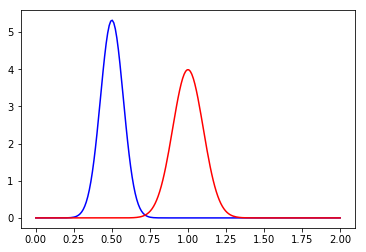

In [3]:
z_ph = np.linspace(0., 2., 200)
plt.plot(z_ph, photoz(z_ph, z_s=0.5), 'b-')
plt.plot(z_ph, photoz(z_ph, z_s=1.0), 'r-')
plt.show()

Now, we must create a new `PhotoZFunction` object to manage the user-defined photo-z pdf. (This allows the function to be called properly by other functions inside CCL, and does some memory management.)

In [4]:
pz_function = ccl.PhotoZFunction(photoz)

Alternatively, CCL has a built-in Gaussian photo-z pdf, `PhotoZGaussian`, that we could have used. This assumes that the photo-z error scales with redshift as $\sigma_z = \sigma_{z,0} (1 + z)$. You can specify $\sigma_{z,0}$ when you create a new instance of `PhotoZGaussian`; here, we set $\sigma_{z,0} = 0.05$:

In [5]:
pz_gaussian = ccl.PhotoZGaussian(0.05)

Note that `PhotoZGaussian` is actually implemented in C rather than Python, so will generally run much faster than any function that you pass to `PhotoZFunction`. For this example, let's use the built-in version.

In [6]:
pz = pz_gaussian

### Calculate the tomographic redshift bin
Now we can calculate dN/dz in a set of tomographic redshift bins, using the `dNdz_tomog` function. This quantity is essentially the true redshft distribution of sources, dN/dz, convolved with a photo-z model, and normalized. First, let's take a look at its call signature:

In [7]:
help(ccl.dNdz_tomog)

Help on function dNdz_tomog in module pyccl.redshifts:

dNdz_tomog(z, zmin, zmax, pz_func, dNdz_func)
    Calculates dNdz in a particular tomographic bin, convolved
    with a photo-z model (defined by the user), and normalized.
    
    Args:
        z (float or array_like): Spectroscopic redshifts to evaluate dNdz at.
        zmin (float): Minimum photo-z of the bin.
        zmax (float): Maximum photo-z of the bin.
        pz_func (callable): User-defined photo-z function.
        dNdz_func (callable): User-defined true dNdz function.
    
    Return:
        dNdz (float or array_like): tomographic dNdz values evalued at each z.



Let us first define a redshift distribution

In [8]:
def dndz(z,args) :
    return z**2*np.exp(-(z/0.5)**1.5)

redshift_dist=ccl.dNdzFunction(dndz)

We can then call `dNdz_tomog` to get the number counts in a bin like so:

In [9]:
z = np.linspace(0., 2., 100)
dNdz = ccl.dNdz_tomog(z, 0.1, 0.7, pz, redshift_dist)

Note that this can take a little while to calculate. This is slower than in the C version of CCL because the photo-z function is called many times by an integration routine inside the library. Calling a Python function, in this case `photoz()`, is slower than calling an internal C function.

We can now plot the results:

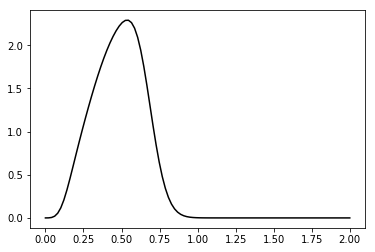

In [10]:
plt.plot(z, dNdz, 'k-')
plt.show()

For the sake of completeness, let's also try a few other redshift bin bounds, more in line with how the LSST bins will be defined:

In [11]:
dNdz1 = ccl.dNdz_tomog(z, 0., 0.6, pz, redshift_dist)

In [12]:
dNdz2 = ccl.dNdz_tomog(z, 0.6, 1.2, pz, redshift_dist)

In [13]:
dNdz3 = ccl.dNdz_tomog(z, 1.2, 1.8, pz, redshift_dist)

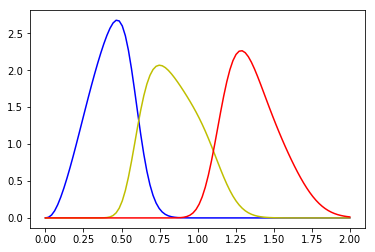

In [14]:
plt.plot(z, dNdz1, 'b-')
plt.plot(z, dNdz2, 'y-')
plt.plot(z, dNdz3, 'r-')
plt.show()